# Guidence on the RDP and DP budget curves

In [1]:
import math
import numpy as np
import pandas as pd
from pynverse import inversefunc
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter("ignore")

from myopacus.accountants.analysis import rdp as privacy_analysis

noise_multiplier = 1.0
target_delta = 1e-3
steps = 5
rounds = 20
client_rate = 0.5
client_rates = [0.2, 0.5, 0.8, 1.0]

# Exponential func
func = lambda x, a, b, c: np.exp(a*x + b) + c
func_str = lambda a, b, c: f"exp({a:.2f}q+{b:.2f}){c:.2f}"

# pre-defined rdp order list
orders = privacy_analysis.generate_rdp_orders()

# pre-defined sampling rates
q_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

In `opacus`, the RDP guarantees will be obtained as follows.

In [3]:
rdp_2 = privacy_analysis.compute_rdp(q=0.1, noise_multiplier=noise_multiplier, steps=steps, orders=orders)
rdp_2

array([8.51843162e-02, 1.58561502e-01, 2.93363035e-01, 6.49387166e-01,
       1.85547177e+00, 4.22356806e+00, 6.89180706e+00, 9.56528905e+00,
       1.22140819e+01, 1.48380368e+01, 1.74412660e+01, 2.00279638e+01,
       2.26015744e+01, 2.51647628e+01, 3.02675221e+01, 3.28098456e+01,
       3.53474683e+01, 3.78811314e+01, 4.29388400e+01, 4.54637598e+01,
       5.05073693e+01, 5.30265575e+01, 5.80606699e+01, 6.30900771e+01,
       6.81156898e+01, 7.31381980e+01, 8.06672710e+01, 8.56841028e+01,
       9.32062715e+01, 1.00725417e+02, 1.08242119e+02, 1.15756816e+02,
       1.25773872e+02, 1.33285093e+02, 1.45801382e+02, 1.55812636e+02,
       1.65822604e+02, 1.78333569e+02, 1.93344940e+02, 2.05853203e+02,
       2.23363280e+02, 2.38370782e+02, 2.55878462e+02, 2.73385190e+02,
       2.93391926e+02, 3.15898514e+02, 3.38404248e+02, 3.63409807e+02,
       3.88414666e+02, 4.18419747e+02, 4.48424162e+02, 4.78428034e+02,
       5.13431989e+02, 5.50935678e+02, 5.88438903e+02, 6.30942102e+02,
      

# Vision of the approximated sampling curve

In [5]:
results_sgd = {
    'rdp_curve':[],
    'eps_curve':[], 
    'opt_eps': [], 
    'opt_order':[]
}
for q in q_examples:
    rdp_vec = privacy_analysis.compute_rdp(q=q, client_q=client_rate, noise_multiplier=noise_multiplier, steps=steps*rounds, orders=orders)
    eps_vec = (
        np.atleast_1d(rdp_vec)
        - (np.log(target_delta) + np.log(orders)) / (orders - 1)
        + np.log((orders - 1) / orders)
    )
    idx_opt = np.nanargmin(eps_vec)
    results_sgd["rdp_curve"].append(rdp_vec)
    results_sgd['eps_curve'].append(eps_vec)
    results_sgd['opt_eps'].append(eps_vec[idx_opt])
    results_sgd['opt_order'].append(orders[idx_opt])
    print("q=", q, ", opt order=", orders[idx_opt], ", opt eps=", eps_vec[idx_opt], ", delta=", target_delta)

q= 0.001 , opt order= 14 , opt eps= 0.28180868416120836 , delta= 0.001
q= 0.01 , opt order= 8 , opt eps= 0.6455921034649802 , delta= 0.001
q= 0.1 , opt order= 3 , opt eps= 5.6703364173865 , delta= 0.001
q= 0.5 , opt order= 2 , opt eps= 41.2588628687411 , delta= 0.001
q= 0.9 , opt order= 2 , opt eps= 92.72642919928745 , delta= 0.001
q= 1.0 , opt order= 2 , opt eps= 105.52146091786224 , delta= 0.001


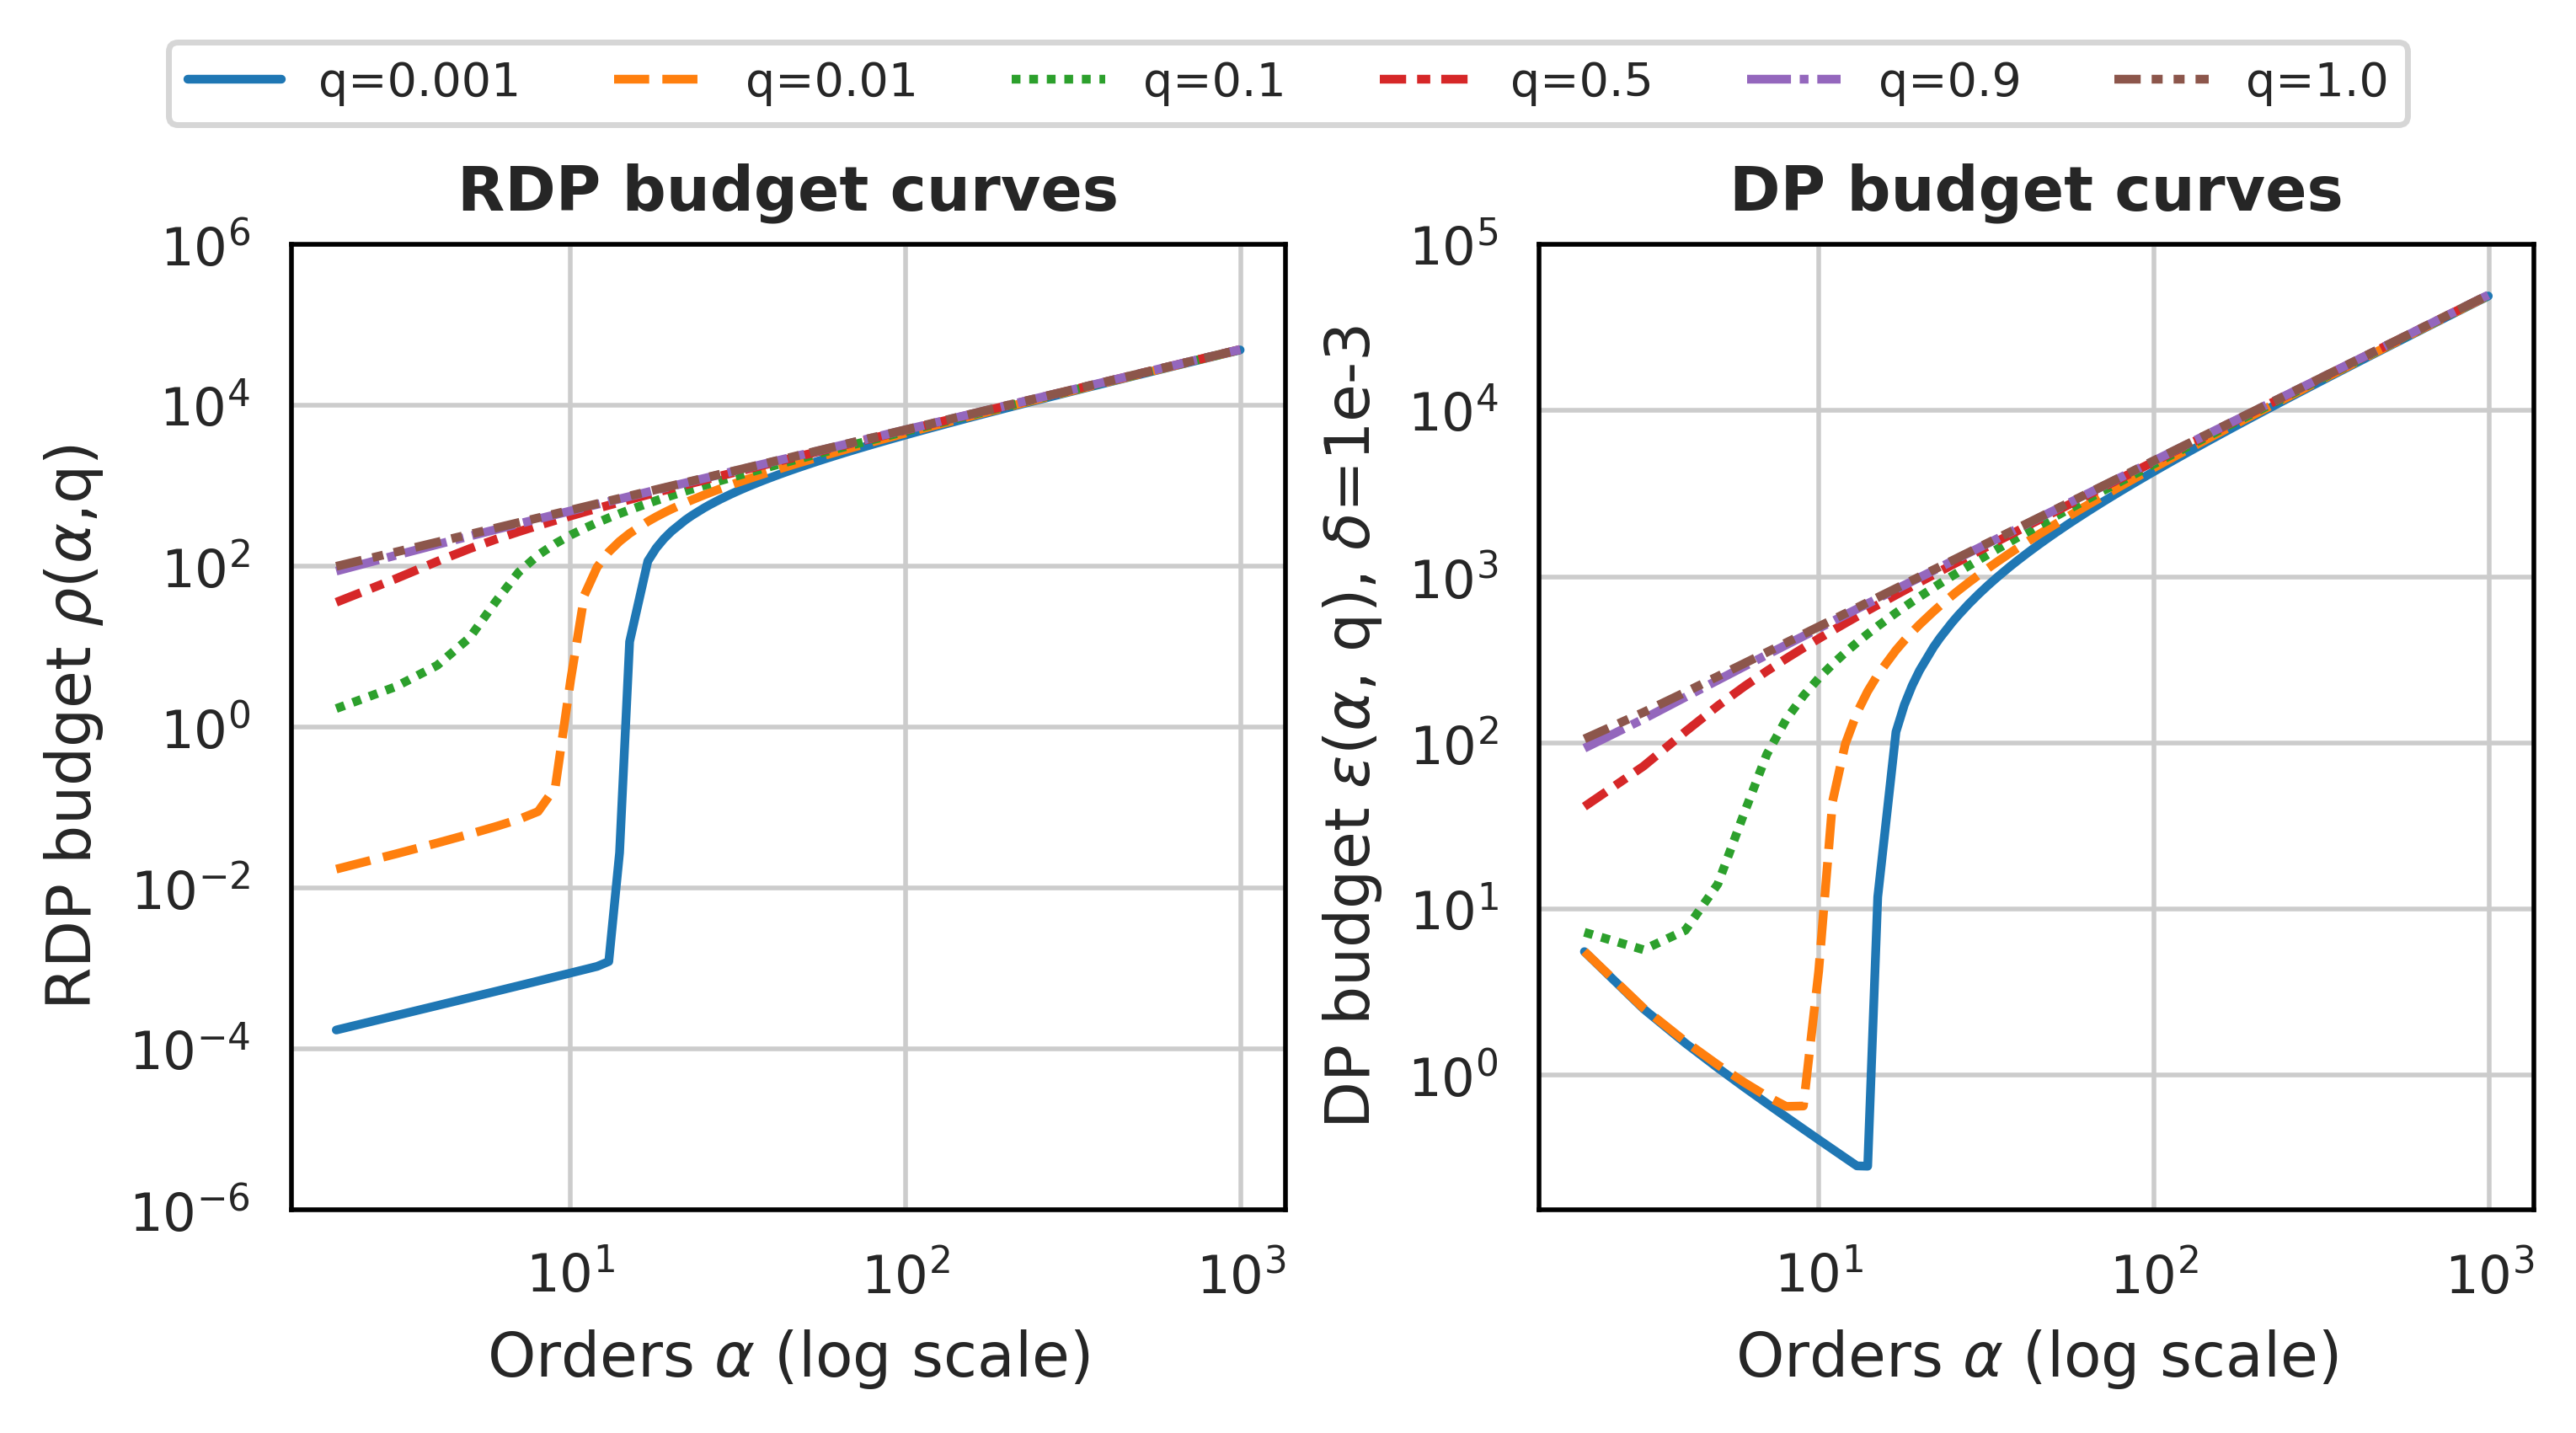

In [6]:
# Vision
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

# rdp curve w.r.t. order alpha
colname = [f'q={q}' for q in q_examples]
df1 = pd.DataFrame(results_sgd['rdp_curve'], columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
sns.lineplot(data=df1_T, ax=axs[0])
axs[0].set(xscale="log", yscale="log")
axs[0].get_legend().remove()
axs[0].set_ylim(1e-6, 1e6)
axs[0].set_ylabel(r'RDP budget $\rho$($\alpha$,q)', **label_font)
axs[0].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
axs[0].tick_params(labelsize=9)
axs[0].set_title('RDP budget curves', **title_font)

# dp curve w.r.t. order alpha
df2 = pd.DataFrame(results_sgd['eps_curve'], columns=orders, index=colname)
df2_T = pd.DataFrame(df2.T, columns=colname, index=orders)
sns.lineplot(data=df2_T, ax=axs[1])
axs[1].set(xscale="log", yscale="log")
axs[1].get_legend().remove()
axs[1].set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
axs[1].set_ylim(0, 100000)
axs[1].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
axs[1].tick_params(labelsize=9)
axs[1].set_title(r'DP budget curves', **title_font)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor = (0, 0.1, 1, 1), ncol=len(labels), prop=legend_font)
# plt.savefig('budget_curve_sgd.pdf', dpi=500, bbox_inches='tight')
plt.show()

## 2 RDP & DP budget curves (FedAvg)

In [7]:
results_fedavg = {
    'rdp_curve':[],
    'eps_curve':[], 
    'opt_eps': [], 
    'opt_order':[]
}
for q in q_examples:
    rdp_vec = privacy_analysis.compute_rdp_fed(q=q, client_q=client_rate, noise_multiplier=noise_multiplier, steps=steps, rounds=rounds, orders=orders)
    eps_vec = (
        np.atleast_1d(rdp_vec)
        - (np.log(target_delta) + np.log(orders)) / (orders - 1)
        + np.log((orders - 1) / orders)
    )
    idx_opt = np.nanargmin(eps_vec)
    results_fedavg["rdp_curve"].append(rdp_vec)
    results_fedavg['eps_curve'].append(eps_vec)
    results_fedavg['opt_eps'].append(eps_vec[idx_opt])
    results_fedavg['opt_order'].append(orders[idx_opt])
    print("q=", q, ", opt order=", orders[idx_opt], ", opt eps=", eps_vec[idx_opt], ", delta=", target_delta)

q= 0.001 , opt order= 14 , opt eps= 0.26809273811296097 , delta= 0.001
q= 0.01 , opt order= 9 , opt eps= 0.5617032282737663 , delta= 0.001
q= 0.1 , opt order= 3 , opt eps= 4.209906899600022 , delta= 0.001
q= 0.5 , opt order= 2 , opt eps= 30.49293179416181 , delta= 0.001
q= 0.9 , opt order= 2 , opt eps= 79.11737156960056 , delta= 0.001
q= 1.0 , opt order= 2 , opt eps= 91.7928242764457 , delta= 0.001


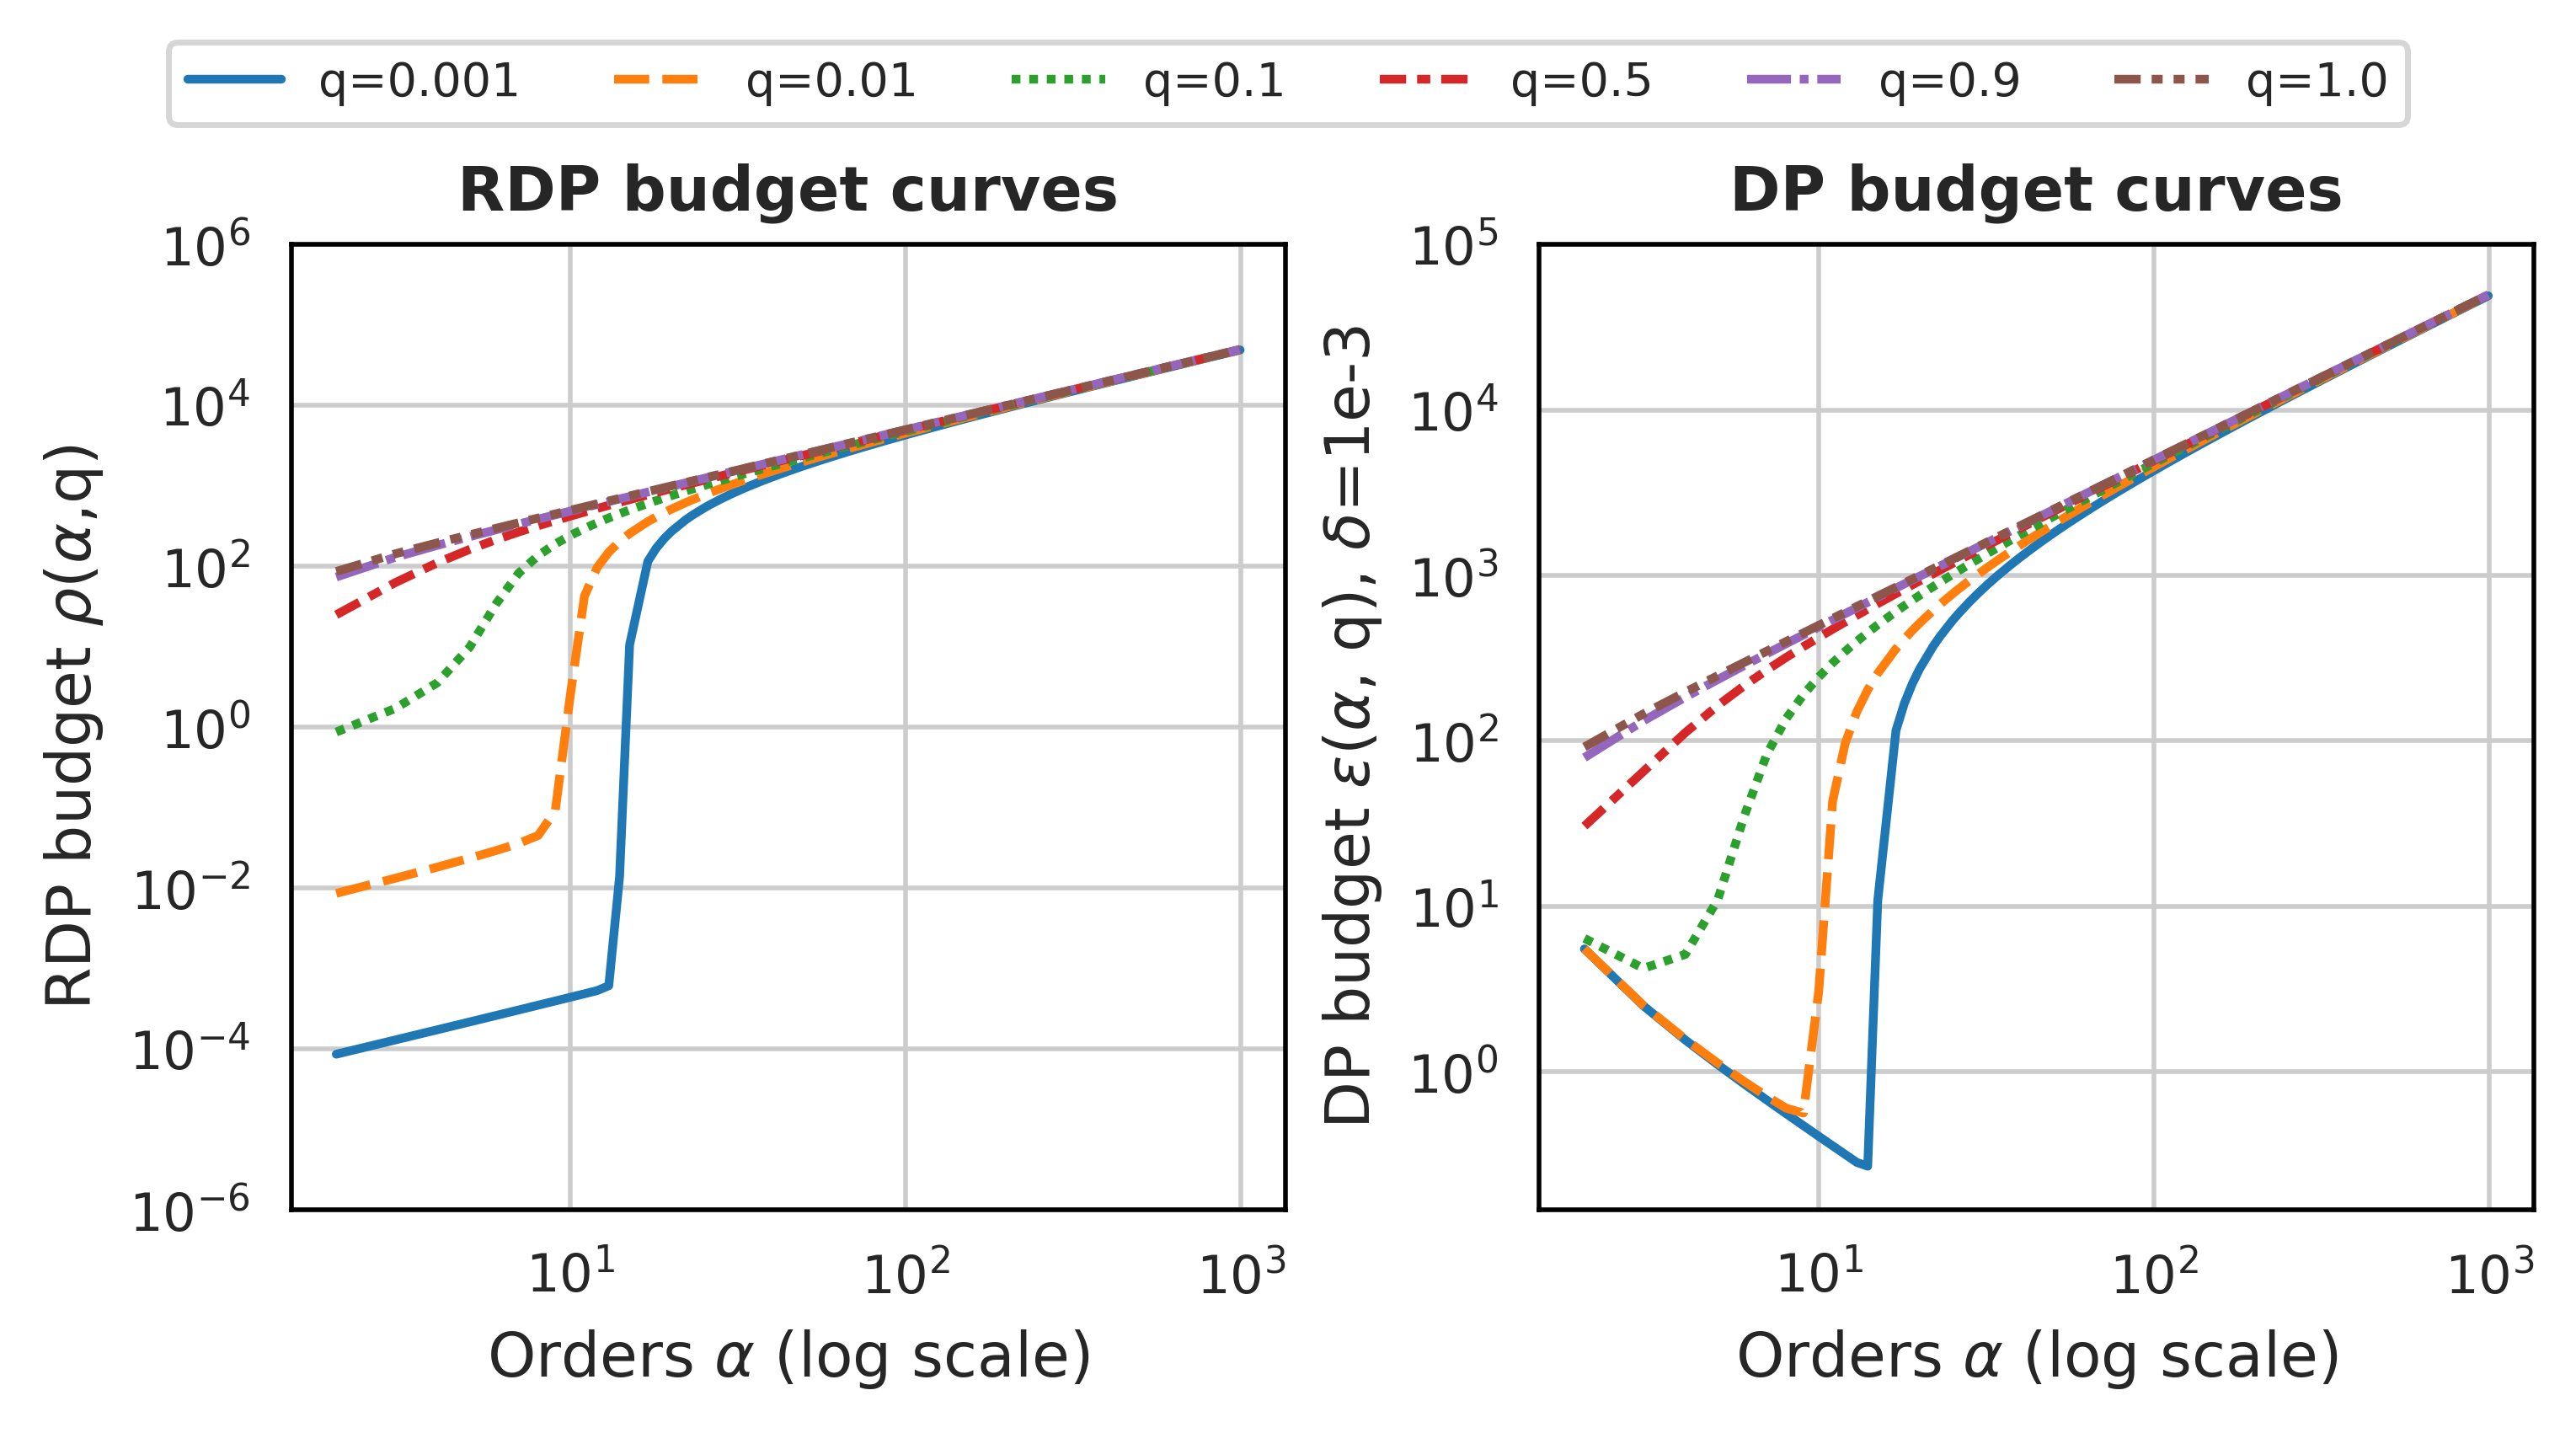

In [8]:
# Vision
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

# rdp curve w.r.t. order alpha
colname = [f'q={q}' for q in q_examples]
df1 = pd.DataFrame(results_fedavg['rdp_curve'], columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
sns.lineplot(data=df1_T, ax=axs[0])
axs[0].set(xscale="log", yscale="log")
axs[0].get_legend().remove()
axs[0].set_ylim(1e-6, 1e6)
axs[0].set_ylabel(r'RDP budget $\rho$($\alpha$,q)', **label_font)
axs[0].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
axs[0].tick_params(labelsize=9)
axs[0].set_title('RDP budget curves', **title_font)

# dp curve w.r.t. order alpha
df2 = pd.DataFrame(results_fedavg['eps_curve'], columns=orders, index=colname)
df2_T = pd.DataFrame(df2.T, columns=colname, index=orders)
sns.lineplot(data=df2_T, ax=axs[1])
axs[1].set(xscale="log", yscale="log")
axs[1].get_legend().remove()
axs[1].set_ylabel(r'DP budget $\varepsilon$($\alpha$, q), $\delta$=1e-3', **label_font)
axs[1].set_ylim(0, 100000)
axs[1].set_xlabel(r'Orders $\alpha$ (log scale)', **label_font)
axs[1].tick_params(labelsize=9)
axs[1].set_title(r'DP budget curves', **title_font)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor = (0, 0.1, 1, 1), ncol=len(labels), prop=legend_font)
# plt.savefig('budget_curve_fedavg.pdf', dpi=500, bbox_inches='tight')
plt.show()

# simu_results_sgd_full, simu_results_fed_full

In [9]:
sample_rates = []
tmp_list = [1,2,3,4,5,6,7,8,9,10]
for mul in [0.1,0.01,0.001]:
    sample_rates.extend(list(map(lambda x: x * mul, tmp_list)))
sample_rates = sorted(np.unique(sample_rates))[1:] # delete q = 0.0
q_candidates = np.array(sample_rates, dtype=np.float32)

In [10]:
all_results = []
results = {
    'rdp_curve':[],
    'eps_curve':[], 
    'opt_eps': [], 
    'opt_order':[]
}
for q in q_candidates:
    rdp_vec = privacy_analysis.compute_rdp(q=q, noise_multiplier=noise_multiplier, steps=steps*rounds, orders=orders)
    eps_vec = (
        np.atleast_1d(rdp_vec)
        - (np.log(target_delta) + np.log(orders)) / (orders - 1)
        + np.log((orders - 1) / orders)
    )
    idx_opt = np.nanargmin(eps_vec)
    results["rdp_curve"].append(rdp_vec)
    results['eps_curve'].append(eps_vec)
    results['opt_eps'].append(eps_vec[idx_opt])
    results['opt_order'].append(orders[idx_opt])
    print("q=", q, ", opt order=", orders[idx_opt], ", opt eps=", eps_vec[idx_opt], ", delta=", target_delta)
all_results.append(results)
    
for client_q in client_rates:
    results = {
        'rdp_curve':[],
        'eps_curve':[], 
        'opt_eps': [], 
        'opt_order':[]
    }
    for q in q_candidates:
        rdp_vec = privacy_analysis.compute_rdp_fed(q=q, client_q=client_q, noise_multiplier=noise_multiplier, steps=steps, rounds=rounds, orders=orders)
        eps_vec = (
            np.atleast_1d(rdp_vec)
            - (np.log(target_delta) + np.log(orders)) / (orders - 1)
            + np.log((orders - 1) / orders)
        )
        idx_opt = np.nanargmin(eps_vec)
        results["rdp_curve"].append(rdp_vec)
        results['eps_curve'].append(eps_vec)
        results['opt_eps'].append(eps_vec[idx_opt])
        results['opt_order'].append(orders[idx_opt])
        print("q=", q, ", opt order=", orders[idx_opt], ", opt eps=", eps_vec[idx_opt], ", delta=", target_delta)
    all_results.append(results)


q= 0.002 , opt order= 12 , opt eps= 0.32135664608588377 , delta= 0.001
q= 0.003 , opt order= 11 , opt eps= 0.3665796385173047 , delta= 0.001
q= 0.004 , opt order= 11 , opt eps= 0.40968853159542284 , delta= 0.001
q= 0.005 , opt order= 10 , opt eps= 0.4360016738179651 , delta= 0.001
q= 0.006 , opt order= 10 , opt eps= 0.47280992980793973 , delta= 0.001
q= 0.007 , opt order= 9 , opt eps= 0.5196184308445175 , delta= 0.001
q= 0.008 , opt order= 9 , opt eps= 0.543022945356923 , delta= 0.001
q= 0.009 , opt order= 9 , opt eps= 0.5815043987428246 , delta= 0.001
q= 0.01 , opt order= 8 , opt eps= 0.6455920984283479 , delta= 0.001
q= 0.02 , opt order= 7 , opt eps= 1.0785412061887467 , delta= 0.001
q= 0.03 , opt order= 5 , opt eps= 1.6229279700087116 , delta= 0.001
q= 0.04 , opt order= 5 , opt eps= 2.1487194503394305 , delta= 0.001
q= 0.05 , opt order= 4 , opt eps= 2.694431826242897 , delta= 0.001
q= 0.06 , opt order= 4 , opt eps= 3.2904085491581263 , delta= 0.001
q= 0.07 , opt order= 3 , opt eps= 

q= 0.09 , opt order= 3 , opt eps= 5.029471377789313 , delta= 0.001
q= 0.1 , opt order= 3 , opt eps= 5.670336518703071 , delta= 0.001
q= 0.2 , opt order= 2 , opt eps= 12.168683000083956 , delta= 0.001
q= 0.3 , opt order= 2 , opt eps= 19.90078729790183 , delta= 0.001
q= 0.4 , opt order= 2 , opt eps= 29.81020415512138 , delta= 0.001
q= 0.5 , opt order= 2 , opt eps= 41.2588628687411 , delta= 0.001
q= 0.6 , opt order= 2 , opt eps= 53.67647621376461 , delta= 0.001
q= 0.7 , opt order= 2 , opt eps= 66.60437819686912 , delta= 0.001
q= 0.8 , opt order= 2 , opt eps= 79.70092784862572 , delta= 0.001
q= 0.9 , opt order= 2 , opt eps= 92.72642611623698 , delta= 0.001
q= 1.0 , opt order= 2 , opt eps= 105.52146091786224 , delta= 0.001


0.9987151727435745
0.9983093666365426


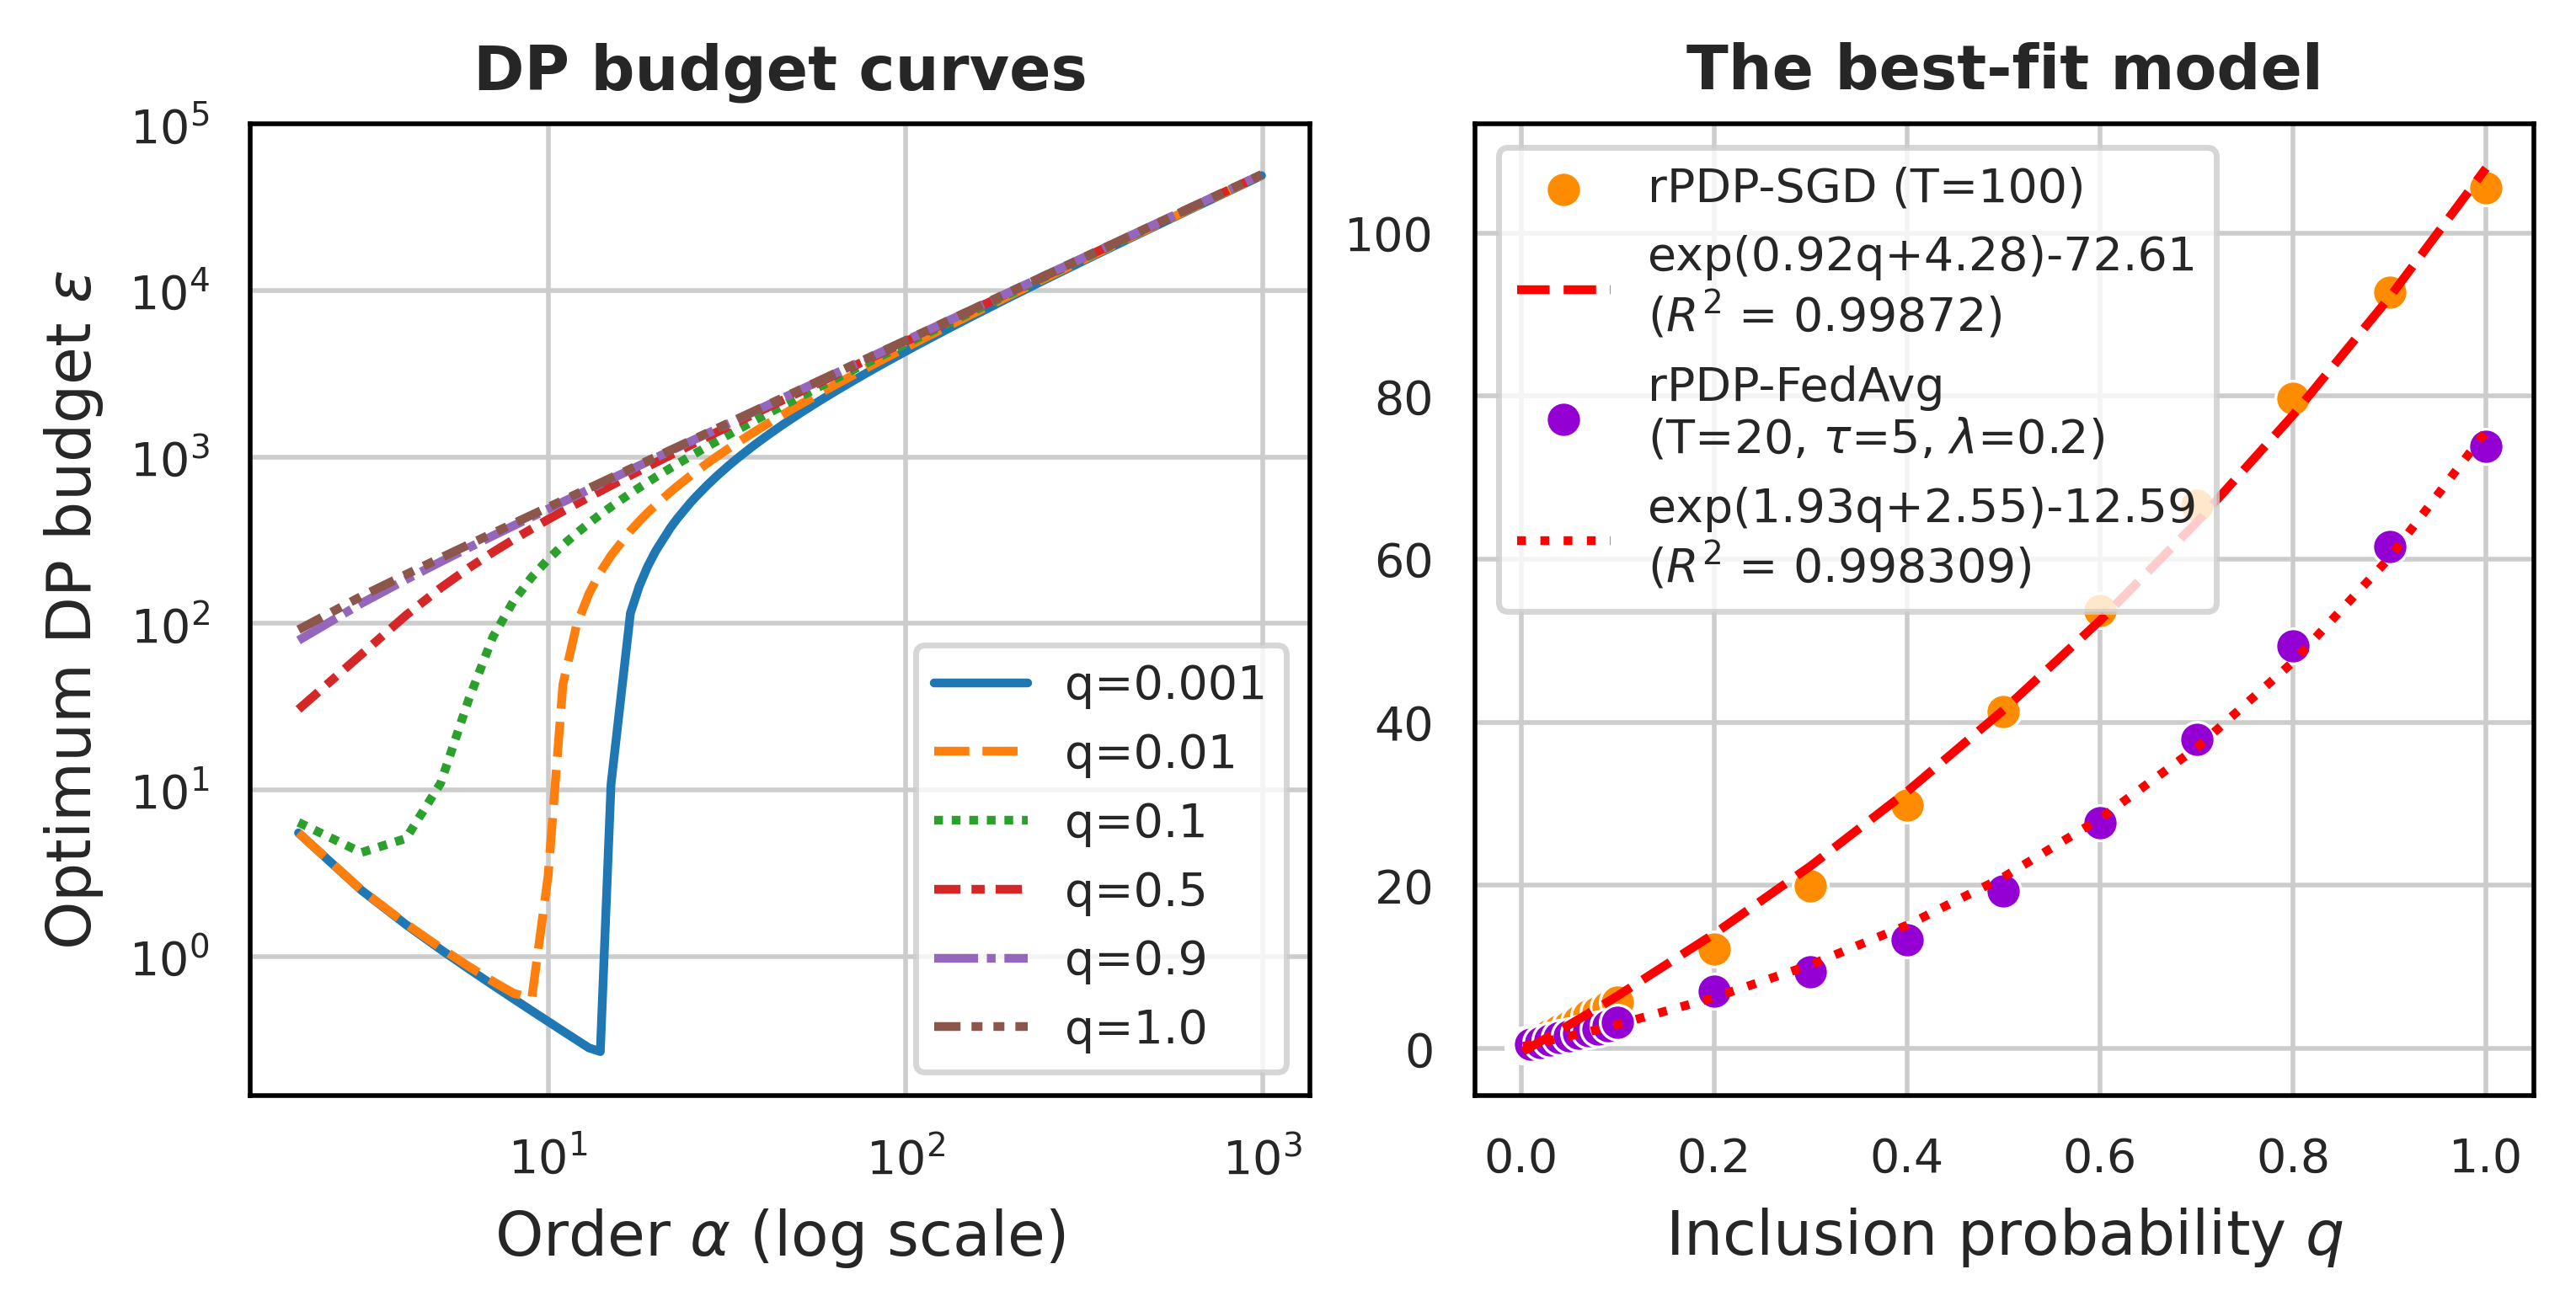

In [11]:
# all_results = [simu_results_fedlearn, simu_results_sgd_full, simu_results_fedlearn_full]
colname = [rf'q={q}' for q in q_examples]

plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True, dpi=500)

# dp curve w.r.t. order alpha
df1 = pd.DataFrame(results_fedavg['eps_curve'], columns=orders, index=colname)
df1_T = pd.DataFrame(df1.T, columns=colname, index=orders)
sns.lineplot(data=df1_T, ax=axs[0])
axs[0].set(xscale="log", yscale="log")
axs[0].set_ylabel(r'DP $\varepsilon(\alpha, \delta)$', **label_font)
axs[0].set_ylim(0, 100000)
axs[0].set_xlabel(r'Order $\alpha$ (log scale)', **label_font)
axs[0].tick_params(labelsize=8)
axs[0].set_title(r'DP budget curves', **title_font)
axs[0].legend(prop=legend_font)

ydata = np.array(all_results[0]['opt_eps'], dtype=np.float32)
popt1, pcov = curve_fit(func, q_candidates, ydata)
score = r2_score(func(q_candidates, *popt1), ydata)
print(score)

sns.scatterplot(x=q_candidates, y=all_results[0]['opt_eps'], label=f'rPDP-SGD (T={int(rounds*steps)})', color='darkorange', ax=axs[1])
sns.lineplot(x=sample_rates, y=func(q_candidates, *popt1), 
             label=func_str(popt1[0],popt1[1],popt1[2])+f'\n($R^2$ = {score:6.5f})', color='red', linestyle='dashed', ax=axs[1])

ydata = np.array(all_results[1]['opt_eps'], dtype=np.float32)
popt2, pcov = curve_fit(func, q_candidates, ydata)
score = r2_score(func(q_candidates, *popt2), ydata)
print(score)

sns.scatterplot(x=q_candidates, y=all_results[1]['opt_eps'], 
                label=f'rPDP-FedAvg\n(T={rounds}, $\\tau$={steps}, $\lambda$=0.2)', color='darkviolet', ax=axs[1])
sns.lineplot(x=q_candidates, y=func(q_candidates, *popt2), 
             label=func_str(popt2[0],popt2[1],popt2[2])+f'\n($R^2$ = {score:7.6f})', color='red', linestyle='dotted', ax=axs[1])

axs[1].legend(prop=legend_font)
# axs[1].set_ylim(0, 120)
axs[0].set_ylabel(r'Optimum DP budget $\varepsilon$', **label_font)
axs[1].set_xlabel('Sampling probability $q$', **label_font)
axs[1].tick_params(labelsize=8) #刻度
axs[1].set_title(r'The best-fit model', **title_font)

# fig.suptitle('The Sampling Probability Estimation ($\delta$={}, $\sigma$/L={})'.format(target_delta,sigma), fontsize=10, weight='bold')
# plt.savefig('sampling_estimator_fed.pdf', dpi=500, bbox_inches='tight')
plt.show()